In [1]:
# Setup
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

# Hyperparameters from the PPO implementation
total_steps = int(8e6)
num_envs = 32
num_steps = 256

# We store the mean rewards each num_envs * num_steps steps
# Steps taken in M
steps_taken = np.arange(num_envs*num_steps,
                        int(np.ceil(total_steps/(num_envs*num_steps)))*num_envs*num_steps+1,
                        num_envs*num_steps)/1000000

Mounted at /content/gdrive


In [3]:
def decode_experiment_name(name):
  components = name.split('_')
  experiment_name = 'Nature'
  if components[1] == 'i':
    experiment_name = 'Impala'
  if components[2] == 'mx':
    experiment_name += ': Mix Reg'
  elif components[2] == 'rc':
    experiment_name += ': Rand Cut' 
  return experiment_name

In [10]:
# Function that plots the training mean reward as a function of steps for
# each experiment of a specific game
def plot_training(game_name):
  path = '/content/gdrive/MyDrive/Deep Learning Project 2020/Data/' + game_name + '/'

  # Get the stored rewards for each experiment
  rewards = []
  experiment_names = []
  for filename in os.listdir(path):
    if filename.endswith(".pt"):
      experiment_names.append(filename)
      file_load = torch.load(path + filename)
      rewards.append(file_load['Mean Reward'])
  print('Number of experiments done for ' + game_name + ': ' + str(len(experiment_names)))
  print('Experiment names: ' + str(experiment_names))

  # Plot the mean rewards for each experiment
  plt.figure(figsize = (16, 10))
  for i in range(len(experiment_names)):
    mean_rewards = [r.item() for r in rewards[i]] # From tensores to a list of reward values
    plt.plot(steps_taken, mean_rewards, label=decode_experiment_name(experiment_names[i]))
    plt.legend()
  plt.xlabel('Steps (M)')
  plt.ylabel('Mean Reward')
  plt.title(game_name)
  plt.show()

Number of experiments done for Starpilot: 6
Experiment names: ['sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_na_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt']


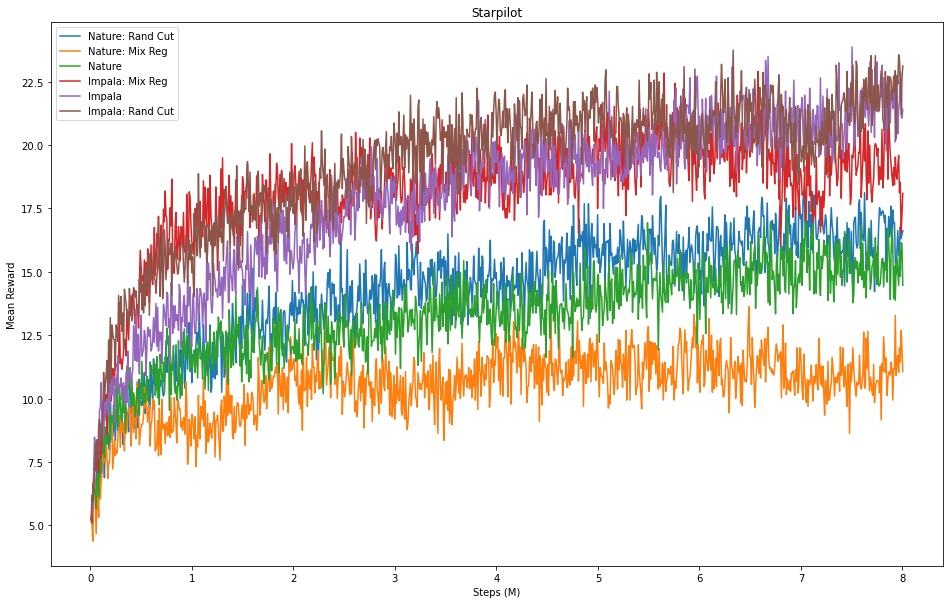

In [11]:
plot_training('Starpilot')

Number of experiments done for Coinrun: 6
Experiment names: ['sd_i_rc_cr.pt', 'sd_i_na_cr.pt', 'sd_n_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_n_rc_cr.pt']


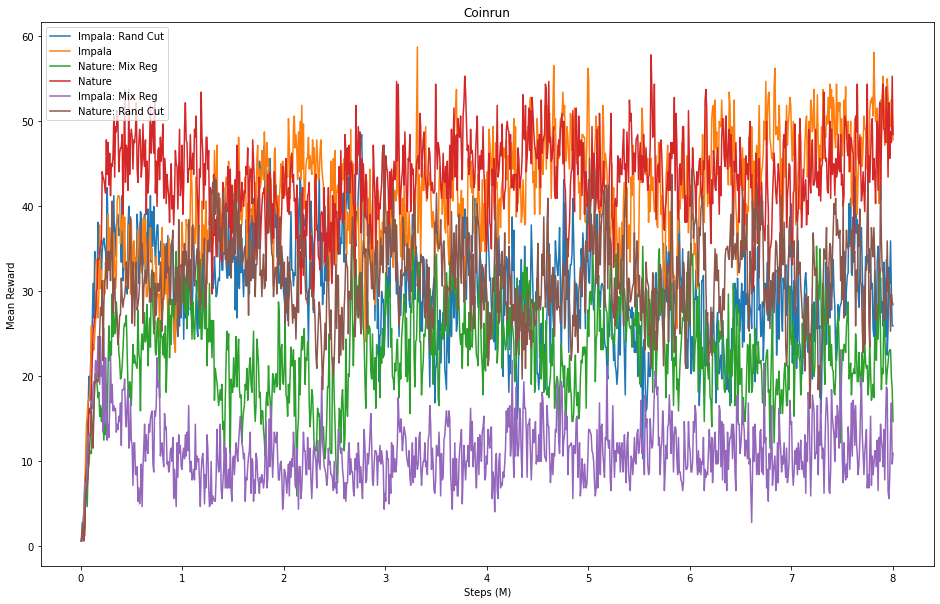

In [12]:
plot_training('Coinrun')

In [ ]:
game_name = 'Starpilot'
path = '/content/gdrive/MyDrive/Data/' + game_name + '/'

print(path)

rewards = []
policies = []
experiment_names = []
for filename in os.listdir(path):
  if filename.endswith(".pt"):
    experiment_names.append(filename)
    file_load = torch.load(path + filename)
    print(file_load.keys())
    rewards.append(file_load['Mean Reward'])
    policies.append(file_load['policy_state_dict'])
print('Number of experiments done for ' + game_name + ': ' + str(len(experiment_names)))

plt.figure(figsize = (16, 10))
for i in range(len(experiment_names)):
  mean_rewards = [r.item() for r in rewards[i]] # From tensores to a list of reward values
  plt.plot(steps_taken, mean_rewards, label=decode_experiment_name(experiment_names[i]))
  plt.legend()
plt.xlabel('Steps (M)')
plt.ylabel('Mean Reward')
plt.title(game_name)
plt.show()